# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
# imports

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
import numpy as np
import os
import sys
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_directory, transform):
        self.transform = transform
        self.data_directory = data_directory
        number_of_classes = 200
        (self.images_path, self.labels) = ([], [])
      
        for directory_number in range(number_of_classes):
            path_to_folder = os.path.join(data_directory, f'class_{directory_number:03d}')
            class_images = list(sorted(os.listdir(path_to_folder)))
            self.images_path.extend(class_images)
            self.labels.extend([directory_number] * len(class_images))

    def __getitem__(self, index):
        path_to_folder = os.path.join(self.data_directory, f'class_{self.labels[index]:03d}')
        path_to_image = os.path.join(path_to_folder, self.images_path[index])

        # В датасете встречаются и черно-белые (c = 1), и цветные изображения (c = 3).
        # Необходимо, чтобы число каналов у всех изображений датасета было одинаково,
        # поэтому приводим все к цветному изображению.
        image = Image.open(path_to_image).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return (image, self.labels[index])
        
    def __len__(self):
        return len(self.images_path)

In [ ]:
!wget https://www.dropbox.com/s/5btu7ieyat87xpl/dataset.zip.. -O dataset.zip
!unzip -q dataset.zip

In [ ]:
transform = transforms.Compose([
                      transforms.Resize((224, 224)),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))])

train_dataset = MyDataset("./dataset/dataset/train", transform=transform)
val_dataset = MyDataset("./dataset/dataset/val", transform=transform)

In [ ]:
train_dataset[0]

(tensor([[[-0.0333, -0.0333, -0.0333,  ..., -0.2490, -0.2529, -0.2529],
          [-0.0333, -0.0333, -0.0333,  ..., -0.2490, -0.2529, -0.2529],
          [-0.0333, -0.0333, -0.0333,  ..., -0.2490, -0.2529, -0.2529],
          ...,
          [ 0.2686,  0.2686,  0.2490,  ...,  0.0373,  0.0373,  0.0373],
          [ 0.3039,  0.3039,  0.2765,  ...,  0.0373,  0.0412,  0.0412],
          [ 0.3039,  0.3039,  0.2765,  ...,  0.0373,  0.0412,  0.0412]],
 
         [[-0.0804, -0.0804, -0.0804,  ..., -0.2098, -0.2137, -0.2137],
          [-0.0804, -0.0804, -0.0804,  ..., -0.2098, -0.2137, -0.2137],
          [-0.0804, -0.0804, -0.0804,  ..., -0.2098, -0.2137, -0.2137],
          ...,
          [-0.3588, -0.3588, -0.3667,  ...,  0.0098,  0.0098,  0.0098],
          [-0.3275, -0.3275, -0.3471,  ...,  0.0098,  0.0137,  0.0137],
          [-0.3275, -0.3275, -0.3471,  ...,  0.0098,  0.0137,  0.0137]],
 
         [[-0.1275, -0.1275, -0.1275,  ..., -0.3549, -0.3588, -0.3588],
          [-0.1275, -0.1275,

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.to(device).train()

    total_loss = 0
    number_of_batches = 0
    predicted_classes = np.array([])
    true_classes = np.array([])    

    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            predicted = model(images)
            loss = criterion(predicted, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            accuracy = (predicted.argmax(1) == labels).float().mean()

            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )

            prbar.update(1)

            total_loss += loss.item()
            predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy())
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())
            number_of_batches += 1

    metrics = {'loss': total_loss / number_of_batches}
    metrics.update({"accuracy": (predicted_classes == true_classes).mean()})

    return metrics

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.to(device).eval()

    total_loss = 0
    number_of_batches = 0
    losses = []
    predicted_classes = np.array([])
    true_classes = np.array([])

    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            predicted = model(images)

            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()

            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            
            prbar.update(1)

            total_loss += loss.item()
            predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy())
            true_classes = np.append(true_classes, labels.cpu().detach().numpy())
            number_of_batches += 1
            losses.append(loss.detach().item())

    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)

    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []

    for epoch in range(n_epochs):
        print(f"Train Epoch: {epoch}")
        train_metrics = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer
        )
        epoch_train_losses.append(train_metrics['loss'])
        
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion
            )
        epoch_eval_losses.append(validation_metrics[0])

In [ ]:
model = resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, 200)
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)
criterion = nn.CrossEntropyLoss()
scheduler = None
n_epochs = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.4441 Accuracy: 1.0: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
tests passed


Запустить обучение можно в ячейке ниже.

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

Train Epoch: 0
Loss: 4.5167 Accuracy: 18.2: 100%|██████████| 200/200 [06:25<00:00,  1.93s/it]
Validation Epoch: 0
Loss: 4.5336 Accuracy: 18.0: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
Train Epoch: 1
Loss: 3.8428 Accuracy: 33.2: 100%|██████████| 200/200 [06:26<00:00,  1.93s/it]
Validation Epoch: 1
Loss: 3.7324 Accuracy: 45.0: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
Train Epoch: 2
Loss: 3.237 Accuracy: 46.2: 100%|██████████| 200/200 [06:24<00:00,  1.92s/it]
Validation Epoch: 2
Loss: 3.4739 Accuracy: 36.0: 100%|██████████| 100/100 [00:29<00:00,  3.33it/s]
Train Epoch: 3
Loss: 3.0287 Accuracy: 46.8: 100%|██████████| 200/200 [06:33<00:00,  1.97s/it]
Validation Epoch: 3
Loss: 2.9703 Accuracy: 39.0: 100%|██████████| 100/100 [00:30<00:00,  3.25it/s]
Train Epoch: 4
Loss: 2.6927 Accuracy: 50.8: 100%|██████████| 200/200 [06:31<00:00,  1.96s/it]
Validation Epoch: 4
Loss: 2.8324 Accuracy: 40.0: 100%|██████████| 100/100 [00:30<00:00,  3.28it/s]
Train Epoch: 5
Loss: 2.4818 Accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))
print(accuracy)

Loss: 2.1459 Accuracy: 52.0: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]
Оценка за это задание составит 5 баллов
0.5452


__Ваш отчёт о проделанных экспериментах__: было решено попробовать зафайнтюнить модель ResNet18 на десяти эпохах. После третьей эпохи accuracy на тесте стало почти стабильно превышать 0.44 и далее увеличивалось при падении значения loss. В итоге после десяти эпох accuracy на тестовой выборке достигло 0.5452, что превышает значения и в 0.44 для первой части задания, и в 0.52 для бонусной части. Было проверно два раза, что после десятой эпохи accuracy превышает 0.52. Если и существует такой шаффл данных, при котором это не выполняется, можно дообучить модель еще на пяти эпохах и далее accuracy должно превысить заданное значение. В виду ненадобности аугментации данных использованы не были.

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [1]:
# we will need this library to process the labeling
! pip install xmltodict
! pip install --upgrade albumentations

     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 36.7MB 83kB/s 
     |████████████████████████████████| 952kB 50.9MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
# imports

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import torchvision.transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt
from sklearn import metrics
import xmltodict, json
import albumentations as A
import albumentations.pytorch
from PIL import ImageDraw

Датасет мы за вас написали.

In [3]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform

        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))

            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())

            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]

            if not isinstance(objects, list):
                objects = [objects]

            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])

            self.annotations.append({
                "boxes": torch.stack(bboxes).float(), 
                "labels": torch.tensor(labels)
                })

    def __getitem__(self, i):
        if self.transform:
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [4]:
!wget https://www.dropbox.com/s/z7z03wqg6xyvqxw/archive.zip?dl=0 -O archive.zip
!unzip -q archive.zip

--2020-11-25 12:11:42--  https://www.dropbox.com/s/z7z03wqg6xyvqxw/archive.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/z7z03wqg6xyvqxw/archive.zip [following]
--2020-11-25 12:11:42--  https://www.dropbox.com/s/raw/z7z03wqg6xyvqxw/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce78022137444a470c839928487.dl.dropboxusercontent.com/cd/0/inline/BD2FrJTaBad6eYhUOTLwbagKKZaCD2HIXMT7O94XBqUL8gGdxIiAHQjj6XJI4gFiY8m99SM1oPkHbJWCaIEENkPbNh8z_1QDX-FhiKDLjuh77HSpaWPhSfO3622J7KypqQ0/file# [following]
--2020-11-25 12:11:42--  https://uce78022137444a470c839928487.dl.dropboxusercontent.com/cd/0/inline/BD2FrJTaBad6eYhUOTLwbagKKZaCD2HIXMT7O94XBqUL8gGdxIiAHQjj6XJI4gFiY8m99SM1oPkHbJWCaIEENkPbNh8z_1QDX-FhiKDLjuh77HSp

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [4]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(intersection_bbox[3] - intersection_bbox[1], 0)
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return metrics.auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [5]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print(f'Loss value after {n} batches is {round(global_loss / n, 2)}')

    return global_loss

def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.eval()
        auc = evaluate(model, val_dataloader, device=device)
        print(f'AUC ON TEST: {auc:04f}')      
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
train_transform = A.Compose([
        # A.HorizontalFlip(p=0.5), что-то не пошло :(
        albumentations.pytorch.transforms.ToTensor()
    ])
val_transform = A.Compose([
        albumentations.pytorch.transforms.ToTensor()
    ])

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)
n_epochs = 5
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


AUC ON TEST: 0.062542
Loss value after 10 batches is 0.71
Loss value after 20 batches is 0.54
Loss value after 30 batches is 0.49
Loss value after 40 batches is 0.47
AUC ON TEST: 0.699489
Loss value after 10 batches is 0.27
Loss value after 20 batches is 0.25
Loss value after 30 batches is 0.23
Loss value after 40 batches is 0.23
AUC ON TEST: 0.870832
Loss value after 10 batches is 0.15
Loss value after 20 batches is 0.16
Loss value after 30 batches is 0.17
Loss value after 40 batches is 0.17
AUC ON TEST: 0.879830
Loss value after 10 batches is 0.14
Loss value after 20 batches is 0.14
Loss value after 30 batches is 0.14
Loss value after 40 batches is 0.14
AUC ON TEST: 0.897783
Loss value after 10 batches is 0.11
Loss value after 20 batches is 0.13
Loss value after 30 batches is 0.13
Loss value after 40 batches is 0.13


auc получился чуть меньше 0.91, поэтому было решено обучить еще одну эпоху:

In [9]:
n_epochs = 1
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


AUC ON TEST: 0.871151
Loss value after 10 batches is 0.14
Loss value after 20 batches is 0.13
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.12


__Выведите итоговое качество модели__.

In [10]:
auc = evaluate(model, val_dataloader, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Оценка за это задание составит 4 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [11]:
iter = iter(val_dataset)

In [12]:
def draw_image(data):
    image, labels = data
    pred = model(image.unsqueeze(0).to(device))[0]
    image = torchvision.transforms.ToPILImage()(image)

    draw = ImageDraw.Draw(image)

    for box in labels['boxes']:
        draw.rectangle([(box[0], box[1]), (box[2], box[3])])
        
    for box in pred['boxes']:
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')

    return image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


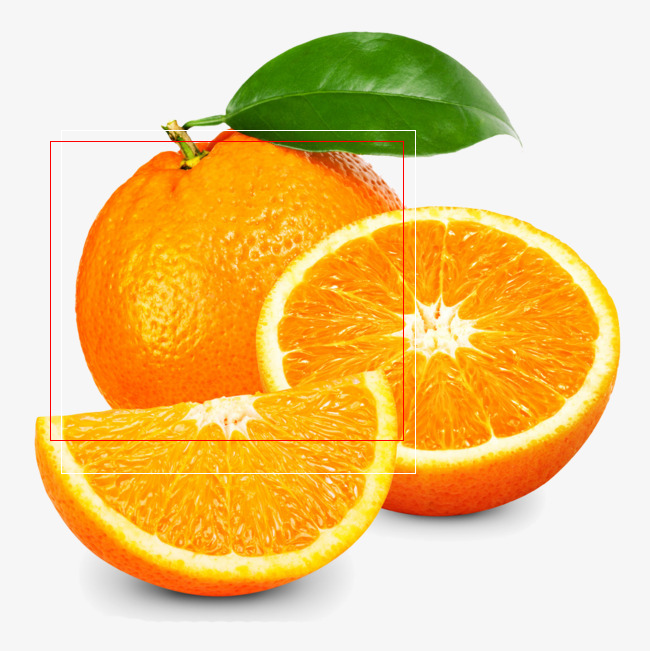

In [14]:
draw_image(next(iter))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


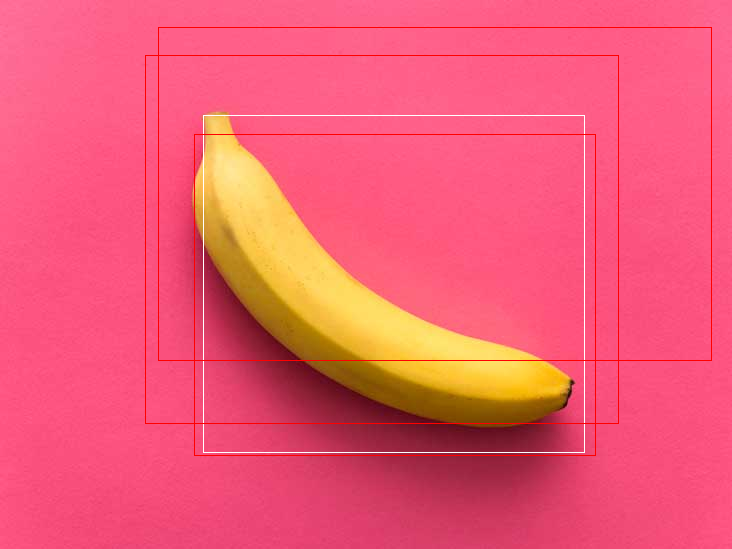

In [15]:
draw_image(next(iter))

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

Accuracy получилось больше 0.52 сразу при выполнении первого задания.

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.
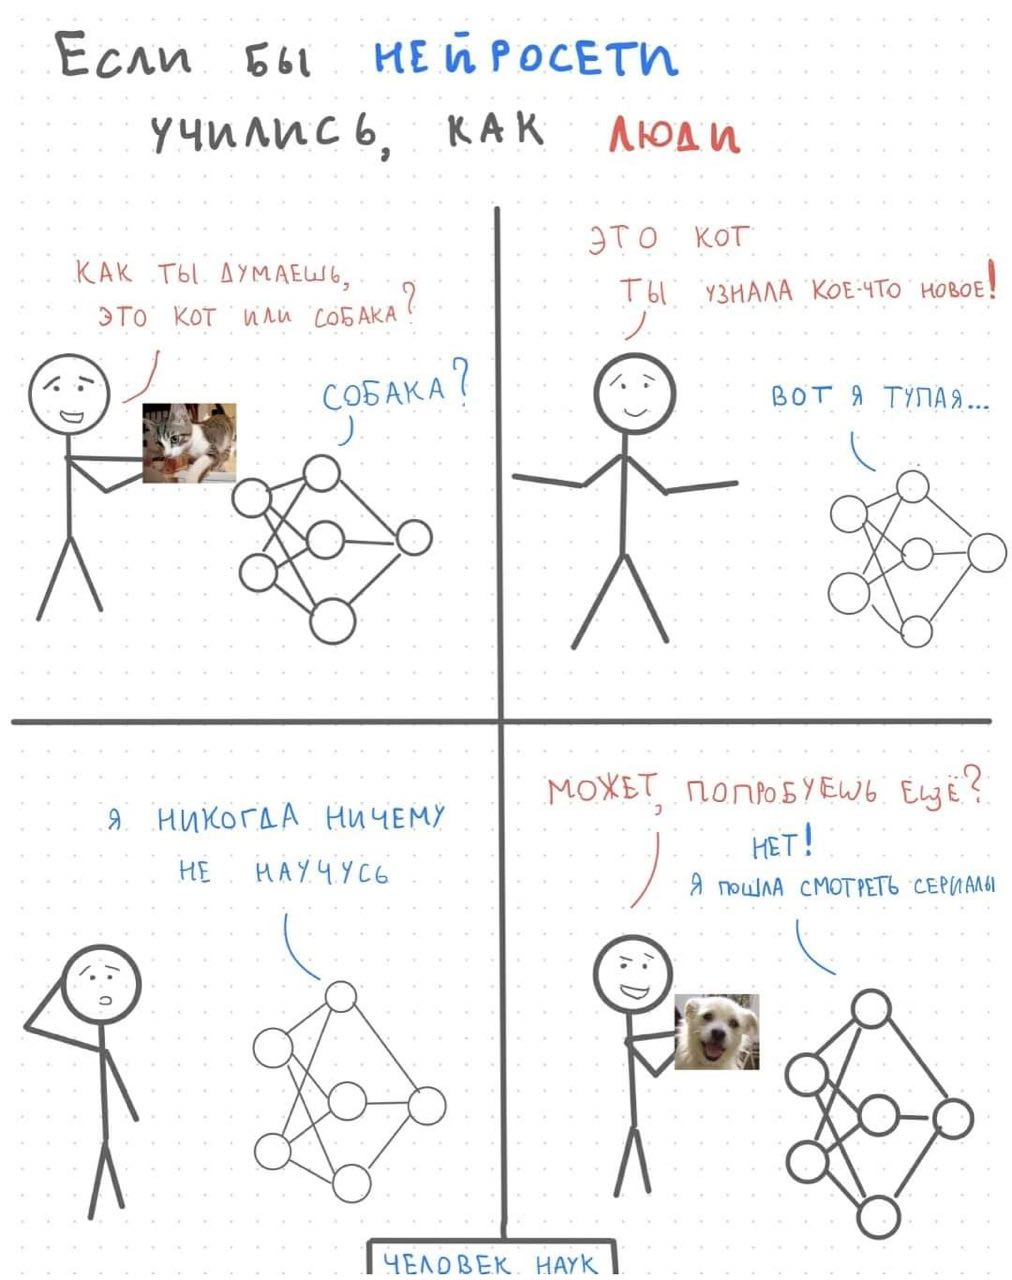

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.


Местами написанный за нас код кидает ошибки компиляции, иногда несоответсвие в именах переменных, немного неприятно с этим разбираться.